# Species classification from single LAS/LAZ with feature & species IDs

This notebook trains a tiny PointNet-style classifier to predict **tree species** from per-tree point clouds extracted from a single LAS/LAZ file that contains:

- `feature_id`: integer ID of the crown / feature for each point
- `species_id`: integer species ID for each point (same species within a feature)

The high-level steps:
- Load the LAS/LAZ file and the corresponding `feature_field_pairs.json` mapping
- Group points by `feature_id` to construct one point cloud per tree
- Derive a single species label per tree and build a dataset
- Train a small PointNet-style model
- Plot training/validation **loss** and **accuracy** curves.


In [7]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Tuple

import laspy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Config
REPO_ROOT = Path.cwd()

# Path to the LAS/LAZ file produced by correspondence/mapping.py
# This file must contain per-point `feature_id` and `species_id` dimensions.
LAS_PATH = REPO_ROOT / "train" / "435_iso_with_feature_ids.laz"

POINTS_PER_TREE = 2048
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
VAL_FRACTION = 0.2
SEED = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda


In [8]:
def robust_xy_radius(xy: np.ndarray) -> float:
    centroid = xy.mean(axis=0)
    diffs = xy - centroid
    r = np.sqrt((diffs * diffs).sum(axis=1))
    return float(np.percentile(r, 95.0))


def robust_z_scale(z: np.ndarray) -> float:
    z_min = float(z.min())
    z_95 = float(np.percentile(z, 95.0))
    scale = z_95 - z_min
    return scale if scale > 0.0 else 1.0


def sample_points(points: np.ndarray, num: int) -> np.ndarray:
    n = points.shape[0]
    if n >= num:
        idx = np.random.choice(n, num, replace=False)
    else:
        idx = np.random.choice(n, num, replace=True)
    return points[idx]


class SpeciesFromSingleLasDataset(Dataset):
    """Dataset that builds one crown (tree) per feature_id from a single LAS/LAZ file.

    - Uses majority species_id within each feature as the tree label.
    - **Only** reads from the LAS/LAZ file; no external JSON mapping is required.
    - Normalizes each crown (center XY, scale XY radius and Z height).
    """

    def __init__(
        self,
        las_path: Path,
        points_per_tree: int = 1024,
        min_points_per_tree: int = 50,
    ) -> None:
        self.las_path = las_path
        self.points_per_tree = points_per_tree
        self.min_points_per_tree = min_points_per_tree

        if not las_path.exists():
            raise FileNotFoundError(f"LAS/LAZ file not found: {las_path}")

        # Load LAS/LAZ
        las = laspy.read(str(las_path))
        x = np.asarray(las.x, dtype=np.float32)
        y = np.asarray(las.y, dtype=np.float32)
        z = np.asarray(las.z, dtype=np.float32)
        coords = np.stack([x, y, z], axis=1)

        feature_id = np.asarray(las["feature_id"], dtype=np.int64)
        species_id = np.asarray(las["species_id"], dtype=np.int64)

        # Build per-tree clouds and labels
        # We assume: for each feature_id, all points share the same species_id.
        # We also skip:
        #   - feature_id <= 0 (unassigned)
        #   - species_id <= 0 (no species)
        self.clouds: List[np.ndarray] = []
        self.species_ids: List[int] = []

        unique_features = np.unique(feature_id)
        for fid in unique_features:
            if fid <= 0:
                continue  # 0 or negative = unassigned / invalid feature

            mask = feature_id == fid
            pts = coords[mask]
            sp_ids = species_id[mask]

            if pts.shape[0] < self.min_points_per_tree:
                continue

            # All points for this feature must share the same positive species_id
            unique_sp = np.unique(sp_ids)
            # Drop any non-positive IDs
            unique_sp = unique_sp[unique_sp > 0]
            if unique_sp.size != 1:
                # If there is no valid species_id or multiple, skip this feature
                continue

            tree_sp_id = int(unique_sp[0])
            if tree_sp_id <= 0:
                continue

            self.clouds.append(pts)
            self.species_ids.append(tree_sp_id)

        if not self.clouds:
            raise RuntimeError("No valid crowns (features) found with species labels.")

        self.species_ids = np.asarray(self.species_ids, dtype=np.int64)

        # Build compact class indices 0..C-1 and simple names derived from species_id
        unique_species_ids = sorted({int(s) for s in self.species_ids})
        self.species_id_to_class: Dict[int, int] = {
            sid: idx for idx, sid in enumerate(unique_species_ids)
        }
        self.class_to_species_id: Dict[int, int] = {
            idx: sid for sid, idx in self.species_id_to_class.items()
        }
        self.class_names: List[str] = [
            f"species_{sid}" for sid in unique_species_ids
        ]

        # Precompute sampled & normalized clouds and compact labels once
        processed_clouds: List[np.ndarray] = []
        compact_labels: List[int] = []

        for pts, sp_id in zip(self.clouds, self.species_ids):
            pts_sampled = sample_points(pts, self.points_per_tree)
            pts_norm = self._normalize_cloud(pts_sampled)
            processed_clouds.append(pts_norm.astype(np.float32))
            compact_labels.append(self.species_id_to_class[int(sp_id)])

        self.clouds_np = np.stack(processed_clouds, axis=0)  # (N, P, 3)
        self.labels_np = np.asarray(compact_labels, dtype=np.int64)
        self.clouds_tensor = torch.from_numpy(self.clouds_np)
        self.labels_tensor = torch.from_numpy(self.labels_np)

        print(f"Loaded {len(self.clouds)} crowns from {las_path}")
        print("Classes (species_id values):")
        for idx, name in enumerate(self.class_names):
            sid = unique_species_ids[idx]
            print(f"  class {idx}: {name} (raw species_id={sid})")

    def __len__(self) -> int:
        return len(self.clouds)

    def _normalize_cloud(self, pts: np.ndarray) -> np.ndarray:
        # Center
        xyz = pts.astype(np.float32, copy=True)
        centroid = xyz.mean(axis=0, keepdims=True)
        xyz_centered = xyz - centroid

        # Scale XY radius
        r_xy = np.sqrt((xyz_centered[:, 0] ** 2 + xyz_centered[:, 1] ** 2))
        r95 = float(np.percentile(r_xy, 95.0))
        if r95 > 0.0:
            xyz_centered[:, 0:2] /= r95

        # Scale Z to [0, 1], then center
        z = xyz[:, 2]
        z_min = float(z.min())
        z_95 = float(np.percentile(z, 95.0))
        z_scale = z_95 - z_min
        if z_scale <= 0.0:
            z_scale = 1.0
        z_norm = (z - z_min) / z_scale
        z_norm = z_norm - float(z_norm.mean())
        xyz_centered[:, 2] = z_norm

        return xyz_centered

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        x = self.clouds_tensor[idx]  # (P, 3)
        y = int(self.labels_tensor[idx].item())
        return x, y


In [9]:
# Build dataset and train/val split

full_dataset = SpeciesFromSingleLasDataset(
    las_path=LAS_PATH,
    points_per_tree=POINTS_PER_TREE,
    min_points_per_tree=50,
)

num_classes = len(full_dataset.class_names)
print(f"Num classes: {num_classes}")

# Train/val indices
n = len(full_dataset)
indices = np.arange(n)
np.random.shuffle(indices)

n_val = int(VAL_FRACTION * n)
val_idx = indices[:n_val]
train_idx = indices[n_val:]

train_subset = torch.utils.data.Subset(full_dataset, train_idx.tolist())
val_subset = torch.utils.data.Subset(full_dataset, val_idx.tolist())

pin_memory = DEVICE.type == "cuda"

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=False,
    pin_memory=pin_memory,
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    pin_memory=pin_memory,
)

print(f"Train crowns: {len(train_subset)}, Val crowns: {len(val_subset)}")


Loaded 830 crowns from c:\Users\Gleb\Work\OpenForest\dev\tree-cluster\train\435_iso_with_feature_ids.laz
Classes (species_id values):
  class 0: species_1 (raw species_id=1)
  class 1: species_2 (raw species_id=2)
  class 2: species_3 (raw species_id=3)
  class 3: species_4 (raw species_id=4)
  class 4: species_5 (raw species_id=5)
  class 5: species_6 (raw species_id=6)
Num classes: 6
Train crowns: 664, Val crowns: 166


In [10]:
class TinyPointNet(nn.Module):
    """Tiny PointNet-style classifier.

    - Shared MLP (Conv1d with kernel_size=1) over points
    - Global max pooling over points
    - MLP classifier head
    """

    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 256, kernel_size=1),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, P, 3) -> (B, 3, P)
        x = x.transpose(1, 2)
        x = self.mlp(x)  # (B, 256, P)
        x = torch.max(x, dim=2).values  # (B, 256)
        logits = self.fc(x)  # (B, C)
        return logits


model = TinyPointNet(num_classes=num_classes).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

print(model)


TinyPointNet(
  (mlp): Sequential(
    (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
    (5): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=64, out_features=6, bias=True)
  )
)


In [11]:
# Training loop with compact per-epoch logging

train_losses: List[float] = []
val_losses: List[float] = []
train_accs: List[float] = []
val_accs: List[float] = []

num_train_batches = len(train_loader)
num_val_batches = len(val_loader)
print(
    f"Starting training: epochs={NUM_EPOCHS}, "
    f"train_batches={num_train_batches}, val_batches={num_val_batches}",
    flush=True,
)

for epoch in range(1, NUM_EPOCHS + 1):
    # ---- Train ----
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for batch_idx, (xb, yb) in enumerate(train_loader, start=1):
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        total_correct += int((preds == yb).sum().item())
        total_examples += int(yb.size(0))
        total_loss += float(loss.item()) * int(yb.size(0))

    train_loss = total_loss / max(1, total_examples)
    train_acc = total_correct / max(1, total_examples)

    # ---- Validation ----
    model.eval()
    val_total_loss = 0.0
    val_total_correct = 0
    val_total_examples = 0

    with torch.no_grad():
        for batch_idx, (xb, yb) in enumerate(val_loader, start=1):
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)

            preds = logits.argmax(dim=1)
            val_total_correct += int((preds == yb).sum().item())
            val_total_examples += int(yb.size(0))
            val_total_loss += float(loss.item()) * int(yb.size(0))

    val_loss = val_total_loss / max(1, val_total_examples)
    val_acc = val_total_correct / max(1, val_total_examples)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Single, compact line per epoch
    print(
        f"Epoch {epoch:03d}/{NUM_EPOCHS} | "
        f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
        f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}",
        flush=True,
    )

# Show final per-class accuracies on the validation set
model.eval()
class_correct = np.zeros(num_classes, dtype=np.int64)
class_total = np.zeros(num_classes, dtype=np.int64)

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        for t, p in zip(yb.cpu().numpy(), preds.cpu().numpy()):
            class_total[int(t)] += 1
            if int(t) == int(p):
                class_correct[int(t)] += 1

print("\nPer-class validation accuracies:")
for i, name in enumerate(full_dataset.class_names):
    if class_total[i] > 0:
        acc_i = class_correct[i] / class_total[i]
        print(f"  class {i} ({name}): {acc_i:.3f} ({class_correct[i]}/{class_total[i]})")
    else:
        print(f"  class {i} ({name}): no validation examples")


Starting training: epochs=30, train_batches=11, val_batches=3
Epoch 001/30 | train_loss=1.7009, val_loss=1.6243, train_acc=0.384, val_acc=0.361
Epoch 002/30 | train_loss=1.5460, val_loss=1.5938, train_acc=0.384, val_acc=0.361
Epoch 003/30 | train_loss=1.5190, val_loss=1.5757, train_acc=0.384, val_acc=0.361
Epoch 004/30 | train_loss=1.5159, val_loss=1.5889, train_acc=0.384, val_acc=0.361
Epoch 005/30 | train_loss=1.5270, val_loss=1.5880, train_acc=0.384, val_acc=0.361
Epoch 006/30 | train_loss=1.5123, val_loss=1.5876, train_acc=0.384, val_acc=0.361
Epoch 007/30 | train_loss=1.5180, val_loss=1.5750, train_acc=0.384, val_acc=0.361
Epoch 008/30 | train_loss=1.5197, val_loss=1.5791, train_acc=0.384, val_acc=0.361
Epoch 009/30 | train_loss=1.5138, val_loss=1.5890, train_acc=0.384, val_acc=0.361
Epoch 010/30 | train_loss=1.5051, val_loss=1.5789, train_acc=0.384, val_acc=0.361
Epoch 011/30 | train_loss=1.5061, val_loss=1.5792, train_acc=0.384, val_acc=0.361
Epoch 012/30 | train_loss=1.5104, va

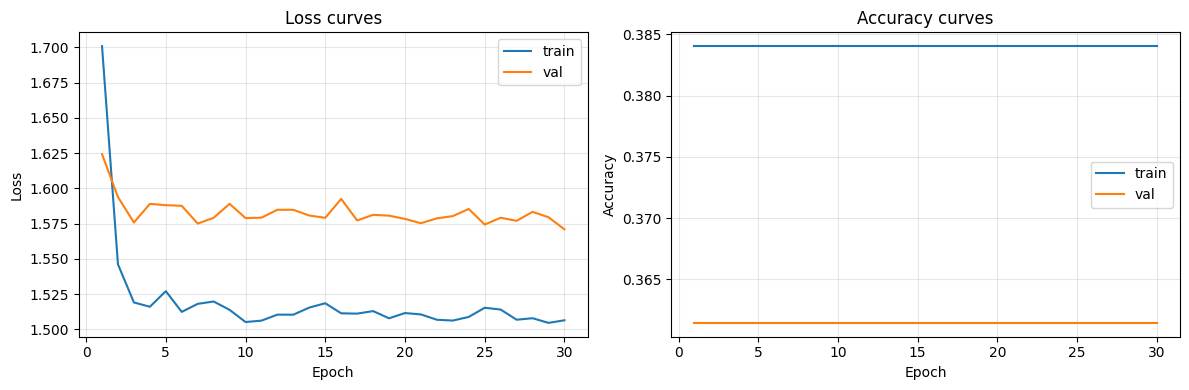

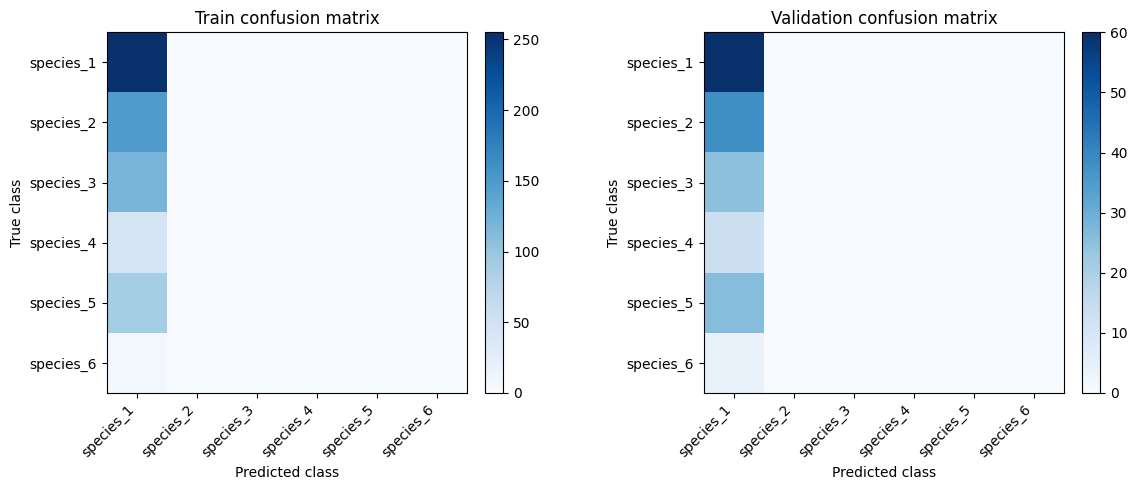

In [12]:
# Plots: loss/accuracy curves and validation confusion matrix

# ----- Loss & accuracy curves -----
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs_arr = np.arange(1, len(train_losses) + 1)

axes[0].plot(epochs_arr, train_losses, label="train")
axes[0].plot(epochs_arr, val_losses, label="val")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss curves")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_arr, train_accs, label="train")
axes[1].plot(epochs_arr, val_accs, label="val")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy curves")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----- Confusion matrices on train and validation sets -----
model.eval()

# Helper to collect predictions and build confusion matrix for a loader

def compute_confusion_matrix(loader: DataLoader, num_classes: int) -> np.ndarray:
    all_targets: List[np.ndarray] = []
    all_preds: List[np.ndarray] = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            all_targets.append(yb.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    if not all_targets:
        return None

    all_targets_arr = np.concatenate(all_targets, axis=0)
    all_preds_arr = np.concatenate(all_preds, axis=0)

    conf_mat = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(all_targets_arr, all_preds_arr):
        conf_mat[int(t), int(p)] += 1
    return conf_mat

conf_mat_train = compute_confusion_matrix(train_loader, num_classes)
conf_mat_val = compute_confusion_matrix(val_loader, num_classes)

# Use class names derived purely from species_id values in the LAS file
species_names = list(full_dataset.class_names)

if conf_mat_train is not None or conf_mat_val is not None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    if conf_mat_train is not None:
        im0 = axes[0].imshow(conf_mat_train, interpolation="nearest", cmap="Blues")
        axes[0].set_title("Train confusion matrix")
        axes[0].set_xlabel("Predicted class")
        axes[0].set_ylabel("True class")
        axes[0].set_xticks(range(num_classes))
        axes[0].set_yticks(range(num_classes))
        axes[0].set_xticklabels(species_names, rotation=45, ha="right")
        axes[0].set_yticklabels(species_names)
        plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    else:
        axes[0].axis("off")
        axes[0].set_title("No train data for confusion matrix")

    if conf_mat_val is not None:
        im1 = axes[1].imshow(conf_mat_val, interpolation="nearest", cmap="Blues")
        axes[1].set_title("Validation confusion matrix")
        axes[1].set_xlabel("Predicted class")
        axes[1].set_ylabel("True class")
        axes[1].set_xticks(range(num_classes))
        axes[1].set_yticks(range(num_classes))
        axes[1].set_xticklabels(species_names, rotation=45, ha="right")
        axes[1].set_yticklabels(species_names)
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    else:
        axes[1].axis("off")
        axes[1].set_title("No validation data for confusion matrix")

    plt.tight_layout()
    plt.show()
else:
    print("No predictions available to build confusion matrices for train/validation.")

